# Dicoding 
## Project Belajar Pengembangan Machine Learning 01
### Projek Analisis Sentimen

Check Python Version: 3.10.12

In [123]:
import sys
print("Python version")
print(sys.version)
print("Version info.")
print(sys.version_info)

Python version
3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Version info.
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


Import Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import spacy 
import string
import warnings 
from wordcloud import WordCloud

# Gensim Pipelines
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords

# NLTK Pipelines
from collections import defaultdict 
from collections import Counter
import nltk 
from nltk import word_tokenize 
from nltk.corpus import stopwords 
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer ,PorterStemmer 
from nltk.tag import pos_tag
nlp = spacy.load("en_core_web_sm") 
warnings.filterwarnings('ignore') 
nltk.download('stopwords') 

# Sklean Pipelines
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# PyTorch Pipelines
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

# TensorFlow Pipelines
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#pip install --upgrade google-api-python-client

In [ ]:
import googleapiclient.discovery


api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "DEVELOPER_KEY"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

comments = []
video_id = "YbJOTdZBX1g" # Youtube Rewind 2018
next_page_token = None

while len(comments) < 30000: # Take 30000 comments
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        pageToken=next_page_token
    )
    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['updatedAt'],
            comment['likeCount'],
            comment['textDisplay']
        ])

    next_page_token = response.get('nextPageToken')
    if not next_page_token:
        break

df = pd.DataFrame(comments, columns=['author', 'published_at', 'updated_at', 'like_count', 'text'])

print(f'Shape: {df.shape}')
df.head(10)

Shape: (30000, 5)


,author,published_at,updated_at,like_count,text
0,@32HandlesLater,2024-12-06T09:43:39Z,2024-12-06T09:43:39Z,0,og brainrot😭
1,@chicken_cranberry,2024-12-06T03:16:15Z,2024-12-06T03:16:15Z,0,"I’ll state that for me, once Drake was brought..."
2,@Calicat023,2024-12-06T01:45:16Z,2024-12-06T01:45:16Z,1,Why is this the most hated video but so good??
3,@chloeanne5901,2024-12-05T22:13:51Z,2024-12-05T22:13:51Z,1,The only good part is the animated pusheen cat
4,@mati124,2024-12-05T22:13:47Z,2024-12-05T22:13:47Z,1,im so proud of this community
5,@lepotdefleur9906,2024-12-05T21:43:35Z,2024-12-05T21:43:35Z,1,20 254 433 dislikes? woah
6,@dexter6052,2024-12-05T21:07:01Z,2024-12-05T21:07:01Z,0,Whose here in 2024?
7,@Youdontknowme-t1f,2024-12-05T20:59:16Z,2024-12-05T20:59:16Z,2,YouTube: We don&#39;t want to promote dangerou...
8,@Dash_o05e,2024-12-05T20:35:45Z,2024-12-05T20:35:45Z,2,bro it&#39;s good idk why yall complained abt ...
9,@Madbum3,2024-12-05T20:19:40Z,2024-12-05T20:19:40Z,2,Will smith.... what a piece of ish.


In [114]:
#df.to_csv('youtubeCommentScrap.csv', index=False)

In [ ]:
chunk_size = 30000
chunks = pd.read_csv('/youtubeCommentScrapDataset.csv', chunksize=chunk_size)

df = pd.concat(chunks, ignore_index=True)

In [5]:
df.describe()

,like_count
count,30000.000000
mean,13.126467
std,358.351687
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,32307.000000


In [6]:
df.isnull().sum()

,0
author,0
published_at,0
updated_at,0
like_count,0
text,0


In [7]:
df.duplicated().sum()

0

In [89]:
df_lstm = df.copy()

In [ ]:
# Function buat text preprocessing
def preprocess_text(text):
    # Convert menjadi lowercase
    text = text.lower()
    # Remove angka dan special character
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text)
    # Remove spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply text preprocessing menjadi column baru 'clean_text'
df['clean_text'] = df['text'].apply(preprocess_text)

df.head()

,author,published_at,updated_at,like_count,text,clean_text
0,@chicken_cranberry,2024-12-06T03:16:15Z,2024-12-06T03:16:15Z,0,"I’ll state that for me, once Drake was brought...",i ll state that for me once drake was brought ...
1,@Calicat023,2024-12-06T01:45:16Z,2024-12-06T01:45:16Z,1,Why is this the most hated video but so good??,why is this the most hated video but so good
2,@chloeanne5901,2024-12-05T22:13:51Z,2024-12-05T22:13:51Z,1,The only good part is the animated pusheen cat,the only good part is the animated pusheen cat
3,@mati124,2024-12-05T22:13:47Z,2024-12-05T22:13:47Z,1,im so proud of this community,im so proud of this community
4,@lepotdefleur9906,2024-12-05T21:43:35Z,2024-12-05T21:43:35Z,1,20 254 433 dislikes? woah,20 254 433 dislikes woah


In [ ]:
nltk.download('vader_lexicon')

# Initialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Menghitung sentiment score
df['sentiment_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Labeling sentiment
def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

# Feature extraction
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(len)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


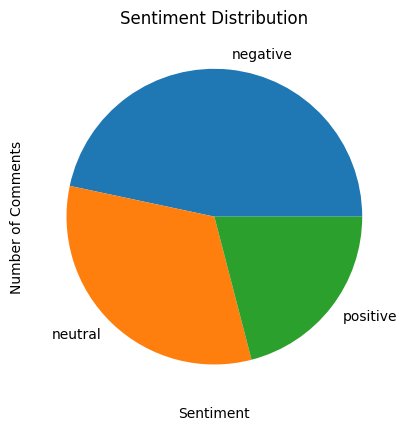

In [ ]:
sentiment_counts = df['sentiment_label'].value_counts()

# Plot distribusi sentimen
sentiment_counts.plot(kind='pie', color=['red', 'blue', 'green'])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.show()

In [12]:
#!pip install wordcloud

In [ ]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


# Filter komen positive, negative, dan neutral 
positive_comments = df[df['sentiment_label'] == 'positive']['text']
negative_comments = df[df['sentiment_label'] == 'negative']['text']
neutral_comments = df[df['sentiment_label'] == 'neutral']['text']

# Kombinasi semua komen
positive_text = ' '.join(positive_comments)
negative_text = ' '.join(negative_comments)
neutral_text = ' '.join(neutral_comments)


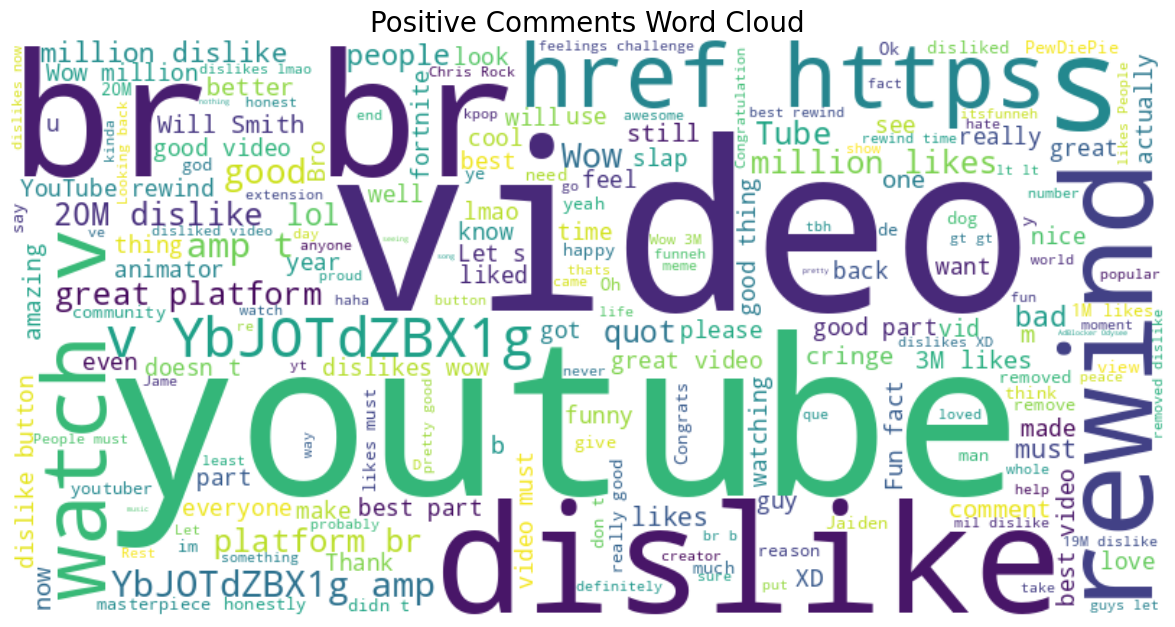

In [14]:

generate_wordcloud(positive_text, 'Positive Comments Word Cloud')


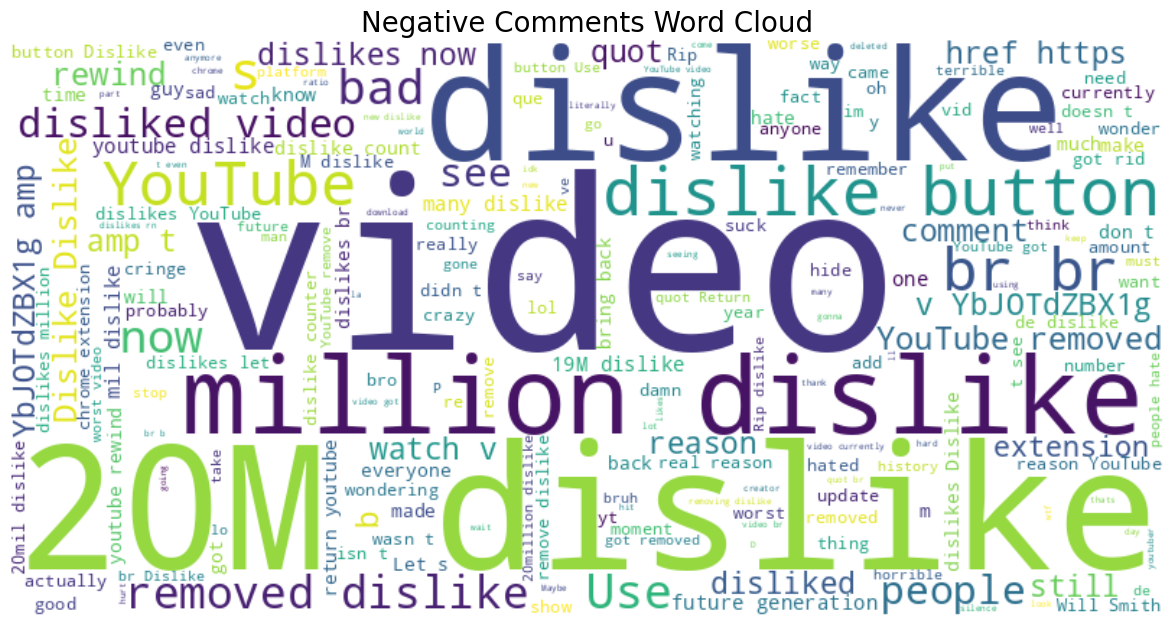

In [15]:
generate_wordcloud(negative_text, 'Negative Comments Word Cloud')

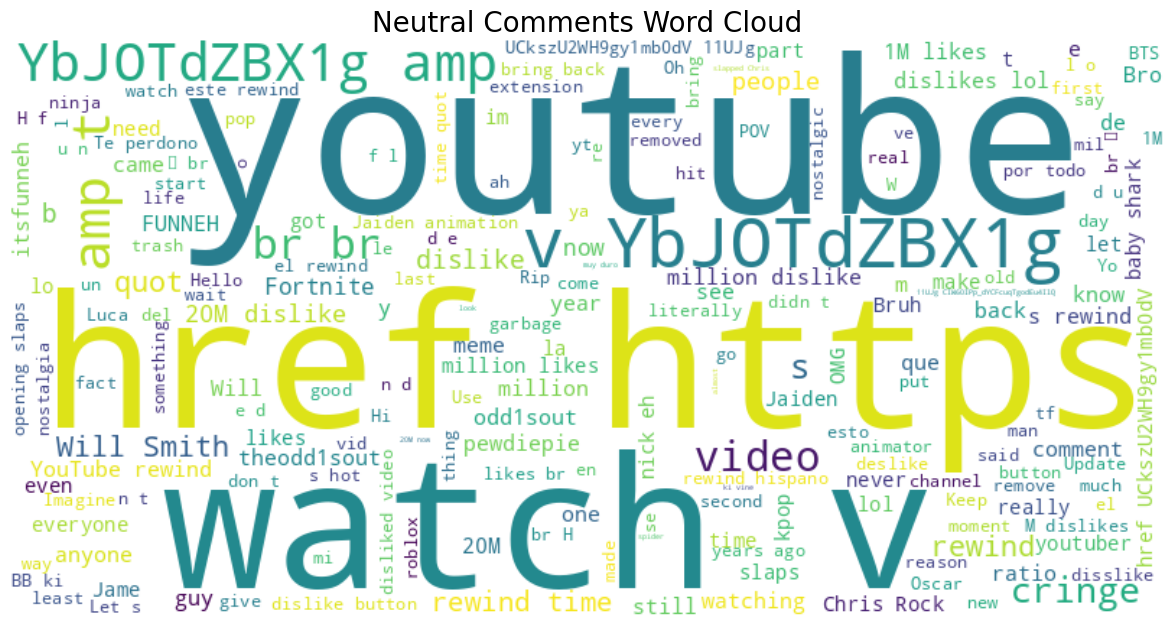

In [16]:
generate_wordcloud(neutral_text, 'Neutral Comments Word Cloud')

## Model Random Forest Word2Vec

In [18]:
# Remove Stopwords
df['clean_text'] = df['clean_text'].apply(remove_stopwords)
df['clean_text']

,clean_text
0,ll state drake brought video song feelings rui...
1,hated video good
2,good animated pusheen cat
3,im proud community
4,20 254 433 dislikes woah
...,...
29995,quot want voice quot br yes taking away critic...
29996,3 million like dislikes br br hmmm legit
29997,video true reason took away dislikes
29998,deslikes


In [19]:
# 1. Tokenize the text
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

In [20]:
# 2. Train the Word2Vec model
from gensim.models import Word2Vec
model = Word2Vec(sentences=df['tokens'], vector_size=100, window=3, min_count=1, workers=3, sg=1)

In [21]:
# 3. Generate document embeddings by averaging word vectors
def get_average_word2vec(tokens_list, model, k=100):
    valid_words = [word for word in tokens_list if word in model.wv.index_to_key]
    if len(valid_words) == 0:
        return np.zeros(k)
    else:
        return np.mean(model.wv[valid_words], axis=0)

df['embedding'] = df['tokens'].apply(lambda x: get_average_word2vec(x, model, k=100))

In [22]:
# 4. Prepare features and labels
X = np.vstack(df['embedding'].values)
y = df['sentiment_label'].map({'positive': 1, 'neutral': 0, 'negative': -1}).values

In [23]:
# 5. Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# 6. Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 7. Train the Logistic Regression model


rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
# 7. Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9325714285714286
Test Accuracy: 0.7942222222222223


## Model Logistic Regression TF-IDF

In [ ]:
# 1. Make model architecture
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()
y = df['sentiment_label'].map({'positive': 1, 'neutral': 0, 'negative': -1}).values

In [ ]:
# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Train the Logistic Regression model
lr_model_tfidf = LogisticRegression(max_iter=1000)
lr_model_tfidf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# 4. Predict on training and test sets
y_train_pred = lr_model_tfidf.predict(X_train)
y_test_pred = lr_model_tfidf.predict(X_test)

# 5. Calculate accuracy on training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 0.9182083333333333
Test Accuracy: 0.8895


## Model LSTM

In [90]:
df_lstm.head()

,author,published_at,updated_at,like_count,text,clean_text,sentiment_score,sentiment_label,word_count,char_count,tokens,embedding
0,@chicken_cranberry,2024-12-06T03:16:15Z,2024-12-06T03:16:15Z,0,"I’ll state that for me, once Drake was brought...",ll state drake brought video song feelings rui...,-0.4767,negative,31,139,"[ll, state, drake, brought, video, song, feeli...","[0.14003515, 0.16355011, -0.25439602, -0.27031..."
1,@Calicat023,2024-12-06T01:45:16Z,2024-12-06T01:45:16Z,1,Why is this the most hated video but so good??,hated video good,0.5212,positive,10,44,"[hated, video, good]","[0.16267416, 0.42009273, -0.26813135, -0.23567..."
2,@chloeanne5901,2024-12-05T22:13:51Z,2024-12-05T22:13:51Z,1,The only good part is the animated pusheen cat,good animated pusheen cat,0.4404,positive,9,46,"[good, animated, pusheen, cat]","[0.13619982, 0.2403, -0.16486037, -0.17341447,..."
3,@mati124,2024-12-05T22:13:47Z,2024-12-05T22:13:47Z,1,im so proud of this community,im proud community,0.5256,positive,6,29,"[im, proud, community]","[0.17290483, 0.17454475, -0.22648847, -0.27478..."
4,@lepotdefleur9906,2024-12-05T21:43:35Z,2024-12-05T21:43:35Z,1,20 254 433 dislikes? woah,20 254 433 dislikes woah,-0.4019,negative,5,24,"[20, 254, 433, dislikes, woah]","[0.14913017, 0.2130026, -0.12265489, -0.121132..."


In [91]:
def clean_comment(comment):
    # Remove URLs
    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE)
    # Remove user @ references and '#' from comment
    comment = re.sub(r'\@\w+|\#','', comment)
    # Remove special characters, numbers, and punctuations
    comment = re.sub(r'\W', ' ', comment)
    comment = re.sub(r'\d', ' ', comment)
    comment = re.sub(r'\s+', ' ', comment)
    comment = comment.strip()
    return comment

In [92]:
df_lstm['clean_text'] = df_lstm['text'].apply(clean_comment)

In [93]:
df_lstm.head()

,author,published_at,updated_at,like_count,text,clean_text,sentiment_score,sentiment_label,word_count,char_count,tokens,embedding
0,@chicken_cranberry,2024-12-06T03:16:15Z,2024-12-06T03:16:15Z,0,"I’ll state that for me, once Drake was brought...",I ll state that for me once Drake was brought ...,-0.4767,negative,31,139,"[ll, state, drake, brought, video, song, feeli...","[0.14003515, 0.16355011, -0.25439602, -0.27031..."
1,@Calicat023,2024-12-06T01:45:16Z,2024-12-06T01:45:16Z,1,Why is this the most hated video but so good??,Why is this the most hated video but so good,0.5212,positive,10,44,"[hated, video, good]","[0.16267416, 0.42009273, -0.26813135, -0.23567..."
2,@chloeanne5901,2024-12-05T22:13:51Z,2024-12-05T22:13:51Z,1,The only good part is the animated pusheen cat,The only good part is the animated pusheen cat,0.4404,positive,9,46,"[good, animated, pusheen, cat]","[0.13619982, 0.2403, -0.16486037, -0.17341447,..."
3,@mati124,2024-12-05T22:13:47Z,2024-12-05T22:13:47Z,1,im so proud of this community,im so proud of this community,0.5256,positive,6,29,"[im, proud, community]","[0.17290483, 0.17454475, -0.22648847, -0.27478..."
4,@lepotdefleur9906,2024-12-05T21:43:35Z,2024-12-05T21:43:35Z,1,20 254 433 dislikes? woah,dislikes woah,-0.4019,negative,5,24,"[20, 254, 433, dislikes, woah]","[0.14913017, 0.2130026, -0.12265489, -0.121132..."


In [94]:
df_lstm['clean_text'] = df_lstm['clean_text'].str.lower()

In [ ]:
sia = SentimentIntensityAnalyzer()

df_lstm['sentiment_score'] = df_lstm['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

def label_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df_lstm['sentiment_label'] = df_lstm['sentiment_score'].apply(label_sentiment)
df_lstm.head(20)

,author,published_at,updated_at,like_count,text,clean_text,sentiment_score,sentiment_label,word_count,char_count,tokens,embedding
0,@chicken_cranberry,2024-12-06T03:16:15Z,2024-12-06T03:16:15Z,0,"I’ll state that for me, once Drake was brought...",i ll state that for me once drake was brought ...,-0.4767,negative,31,139,"[ll, state, drake, brought, video, song, feeli...","[0.14003515, 0.16355011, -0.25439602, -0.27031..."
1,@Calicat023,2024-12-06T01:45:16Z,2024-12-06T01:45:16Z,1,Why is this the most hated video but so good??,why is this the most hated video but so good,0.5212,positive,10,44,"[hated, video, good]","[0.16267416, 0.42009273, -0.26813135, -0.23567..."
2,@chloeanne5901,2024-12-05T22:13:51Z,2024-12-05T22:13:51Z,1,The only good part is the animated pusheen cat,the only good part is the animated pusheen cat,0.4404,positive,9,46,"[good, animated, pusheen, cat]","[0.13619982, 0.2403, -0.16486037, -0.17341447,..."
3,@mati124,2024-12-05T22:13:47Z,2024-12-05T22:13:47Z,1,im so proud of this community,im so proud of this community,0.5256,positive,6,29,"[im, proud, community]","[0.17290483, 0.17454475, -0.22648847, -0.27478..."
4,@lepotdefleur9906,2024-12-05T21:43:35Z,2024-12-05T21:43:35Z,1,20 254 433 dislikes? woah,dislikes woah,-0.4019,negative,5,24,"[20, 254, 433, dislikes, woah]","[0.14913017, 0.2130026, -0.12265489, -0.121132..."
5,@dexter6052,2024-12-05T21:07:01Z,2024-12-05T21:07:01Z,0,Whose here in 2024?,whose here in,0.0000,neutral,4,18,[2024],"[0.15689015, 0.19472644, 0.027997818, -0.29748..."
6,@Youdontknowme-t1f,2024-12-05T20:59:16Z,2024-12-05T20:59:16Z,2,YouTube: We don&#39;t want to promote dangerou...,youtube we don t want to promote dangerous beh...,-0.0516,negative,33,172,"[youtube, 39, t, want, promote, dangerous, beh...","[0.03723181, 0.13219091, -0.20534408, -0.28482..."
7,@Dash_o05e,2024-12-05T20:35:45Z,2024-12-05T20:35:45Z,2,bro it&#39;s good idk why yall complained abt ...,bro it s good idk why yall complained abt it,-0.0516,negative,11,47,"[bro, 39, s, good, idk, yall, complained, abt]","[0.18985426, 0.15398294, -0.18317221, -0.27212..."
8,@Madbum3,2024-12-05T20:19:40Z,2024-12-05T20:19:40Z,2,Will smith.... what a piece of ish.,will smith what a piece of ish,0.0000,neutral,7,30,"[smith, piece, ish]","[0.06177786, -0.04382296, -0.08431706, -0.2974..."
9,@samatha3181,2024-12-05T18:04:46Z,2024-12-05T18:04:46Z,4,"You know what else is massive? <a href=""https:...",you know what else is massive a href,0.0000,neutral,21,94,"[know, massive, href, https, www, youtube, com...","[0.27895573, 0.50054955, -0.24413694, -0.58215..."


In [96]:
df_lstm = df_lstm[['clean_text', 'sentiment_label']]
df_lstm.head()

,clean_text,sentiment_label
0,i ll state that for me once drake was brought ...,negative
1,why is this the most hated video but so good,positive
2,the only good part is the animated pusheen cat,positive
3,im so proud of this community,positive
4,dislikes woah,negative


In [97]:
df_train, df_test = train_test_split(df_lstm, test_size=0.2, random_state=42)

In [ ]:
train_texts = df_train['clean_text'].values
train_labels = df_train['sentiment_label'].values

test_texts = df_test['clean_text'].values
test_labels = df_test['sentiment_label'].values

In [ ]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [ ]:
tokenizer = Tokenizer()  

tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [101]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [102]:
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 798


In [103]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [104]:
input_size = np.max(train_padded) + 1
input_size

10943

In [ ]:
# Make the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(798,)))

# Add a bidirectional LSTM layer with 32 units
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another 16 unit LSTM layer
model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 16 units and ReLU activation
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 3: positive, neutral, and negative
model.add(Dense(3, activation='softmax'))

In [ ]:
# Summarise the model
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 798, 100)            │       1,094,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 798, 64)             │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 798, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 798, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,139,679 (4.35 MB)

 Trainable params: 1,139,487 (4.35 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_padded,
    train_labels_encoded ,
    validation_data=(test_padded,test_labels_encoded),
    epochs=5
)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5238 - loss: 9.4150 - val_accuracy: 0.7782 - val_loss: 0.8597
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.8318 - loss: 0.6840 - val_accuracy: 0.5553 - val_loss: 1.1191
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.8670 - loss: 0.4810 - val_accuracy: 0.6005 - val_loss: 1.7951
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.8980 - loss: 0.4010 - val_accuracy: 0.9067 - val_loss: 0.3513
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 69s 92ms/step - accuracy: 0.9138 - loss: 0.3543 - val_accuracy: 0.8995 - val_loss: 0.4146


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_padded , test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9005 - loss: 0.4110
Test Loss: 0.4145796000957489
Test Accuracy: 0.8995000123977661


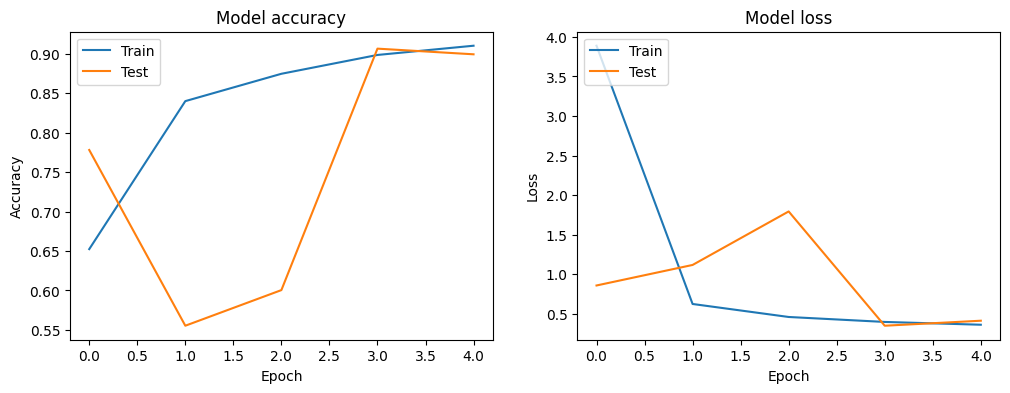

In [110]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

- Kriteria 1: Data merupakan hasil scraping secara mandiri✅
- Kriteria 2: Melakukan tahapan ekstraksi fitur dan pelabelan data✅
- Kriteria 3: Menggunakan algoritma pelatihan machine learning✅
- Kriteria 4: Akurasi testing set yang didapatkan minimal harus mencapai 85%✅

Saran yang terpakai:

1. Menggunakan algoritma deep learning (LSTM)✅
2. Akurasi pada training set dan testing set di atas 92%. (Maxs 90-91%) ❌
3. Dataset memiliki minimal tiga kelas.✅
4. Memiliki jumlah data minimal 10.000 sampel data. (30000)✅
5. Melakukan 3 percobaan skema pelatihan yang berbeda. Skema ini dapat dibedakan dari variasi algoritma pelatihan, metode ekstraksi fitur, pelabelan, dan pembagian data dengan memilih minimal 2 kombinasi. ([Random Forest, Logistic Regression, LSTM], [TF-IDF, Word2Vec], [70/30, 80/20])✅ 
6. Melakukan inference atau testing dalam file .ipynb atau .py yang menghasilkan output berupa kelas kategorikal (contoh: negatif, netral, dan positif). ❌